In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy.signal import stft, butter, lfilter, lfiltic
import control as ct
from scipy.optimize import differential_evolution
from control.matlab import *

sns.set_style('whitegrid')

In [62]:
def clean_df(df):
    df.columns = ['Dado filtrado', 'Dado bruto do bruto', 'Dado bruto', 'Sinal de controle', 'ModoOperacao',
           'Setpoint', 'CicloInicio', 'CicloFim'];
    df.pop('CicloFim')
    df.pop('CicloInicio')
    df.pop('Dado bruto do bruto')
    df.pop('ModoOperacao');

In [63]:
def plot_control(df):
    _df = df.iloc[:800]
    fig, ax = plt.subplots(2, 1, figsize=(13, 10))
    for a in ax:
        a.set_xlabel('Tempo (s)')
        a.set_ylabel('Valor da placa A/D')
    _df[['Dado filtrado', 'Dado bruto', 'Setpoint']].plot(ax=ax[0]);
    _df['Sinal de controle'].plot(ax=ax[1])
    ax[1].legend(['Sinal de controle']);

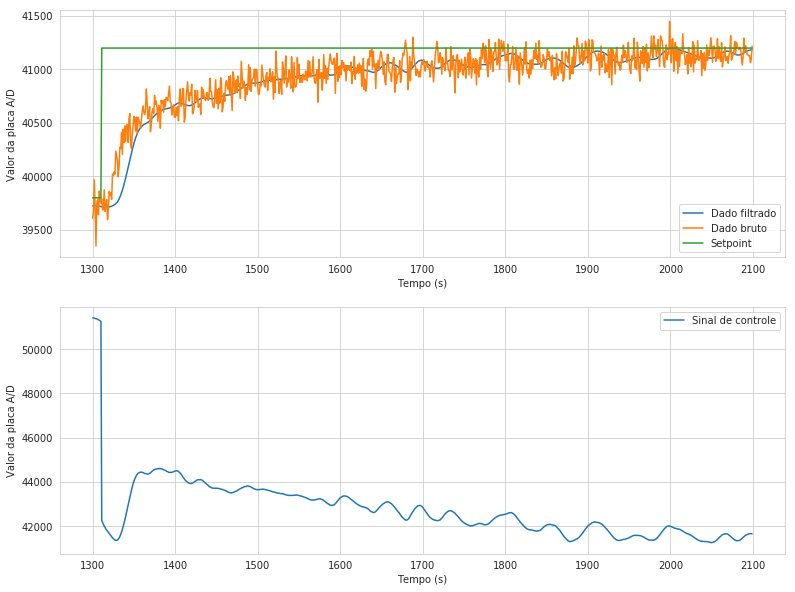

In [64]:
file = './ensaio_certo/Controlador-PI.txt'
df = pd.read_csv(file, sep=' ')

clean_df(df)
plot_control(df.iloc[1300:])

In [65]:
theta = 0#10.41
Tau = 68
TauC = 1
K = -6.42

In [66]:
Kc = (Tau/ (TauC + theta))/ K
Kc

-10.59190031152648

# PI

In [67]:
file = 'ensaio_certo/ControladorPI'
df = pd.read_csv(file, sep=' ')

clean_df(df)

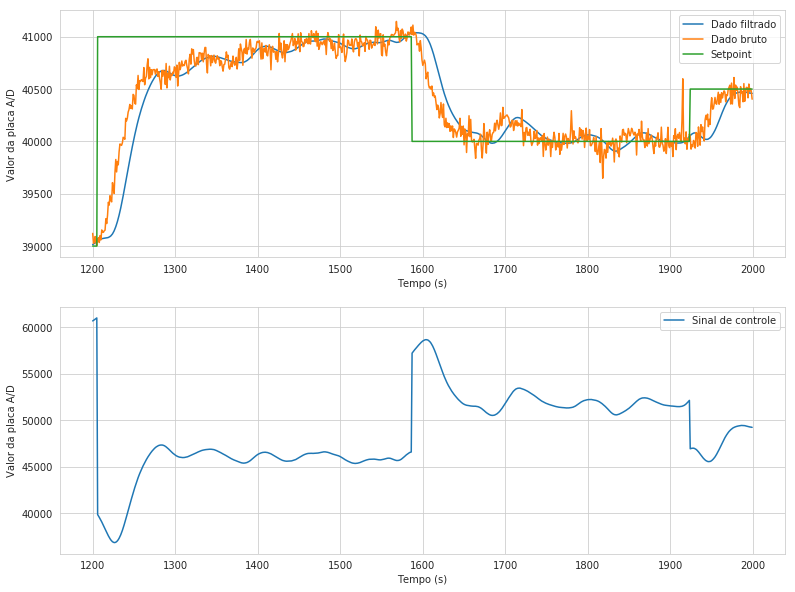

In [77]:
plot_control(df.iloc[1200:])

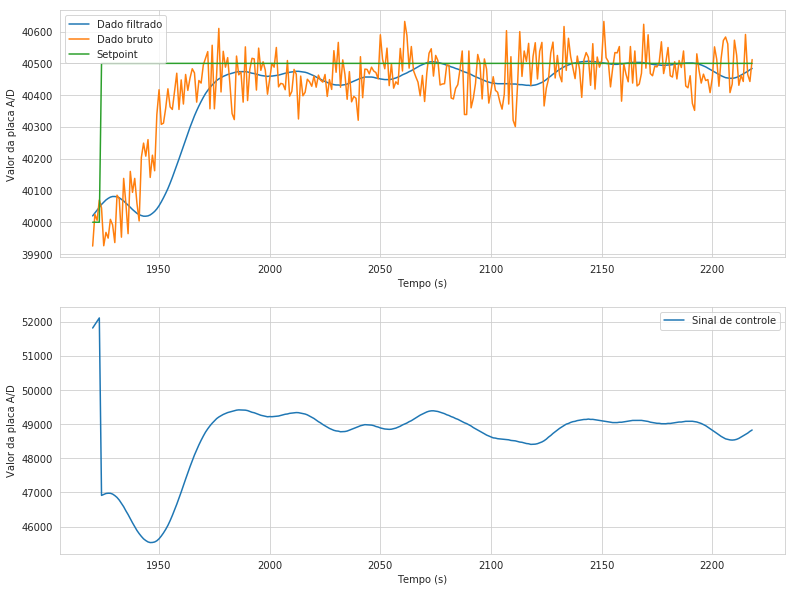

In [79]:
plot_control(df.iloc[1920:])

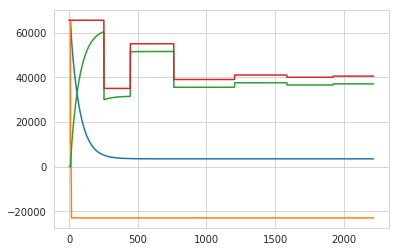

In [119]:
tau = 68;
Kg = -0.15;
th = 9.5;
LS = 10225;
LI= -23000;
t = 1;

#Parâmetros do controlador
kc = -10.6;
Td = 0;
alpha = 0.5;
Ti = 50;
t = 1;

# PID
# kc = -6.42;
# Td = 1;
# alpha = 0.5;
# Ti = 68;


setpoint = df['Setpoint'].values


i = len(setpoint)
y = np.ones((i,1)) * df['Setpoint'].values[0]
u = np.ones((i,1)) * df['Sinal de controle'].values[0]
e = np.zeros((i,1))
ek = np.zeros((i,1))
d = np.zeros((i,1))
a = np.ones((i,1))* df['Setpoint'].values[0]
c = np.ones((i,1))* df['Setpoint'].values[0]
r = np.ones((i,1))* df['Setpoint'].values[0]
g = np.ones((i,1))* df['Setpoint'].values[0]
f = np.zeros((i,1))
ref = np.zeros((i,1))

# ref[120:i] = 26000;
#0 é MANUAL e 1 é AUTO
modo = np.ones((i, 1)); 
 

# setpoint = np.zeros((i,1));
# setpoint[120:i] = 2000;

sys = tf([0, Kg], [tau, 1])

nd = [0, -0.0022]
dd = [1.000, -0.9854]


for k in range(10, i):
    y[k] = nd[1] * u[k-1 - int(th/t)] - dd[1] * y[k-1]
    d[k] = (y[k]*Td + d[k-1]*alpha*Td - y[k-1]*Td) / (t + alpha*Td);
    e[k] = setpoint[k] - y[k]
    ek[k] = kc * e[k]
    
#     if modo[k]:
    r[k] = g[k-1]
#     else:
#         r[k] = ref[k]
    
    a[k] = (r[k] * t + a[k-1] * Ti)/ (t + Ti);
    g[k] = a[k] + ek[k]
        
    if g[k] < LI:
        g[k] = LI
    elif g[k] > LS:
        g[k] = LS
    
#     if modo[k]:
    f[k] = d[k] * kc;
    u[k] = g[k] - f[k];
#     else:
#         u[k] = ref[k];
    
    if u[k] < LI:
        u[k] = LI
    elif u[k] > LS:
        u[k] = LS

plt.plot(y)
plt.plot(u)
plt.plot(e)
plt.plot(setpoint);